In [1]:
# Import 需要的套件
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

### 對資料做前置處理
* object type 且種類 <=2，使用 label enconder
* object type 且種類 >0，使用 one hot encoding
* 針對異常數據 ex: 'DAYS_EMPLOYED' == 365243，使用 np.nan 取代。並將此 value of column 取其絕對值，免於用負數表示

In [2]:
# 設定 data_path
dir_data = './data/'
f_app_train = os.path.join(dir_data, 'application_train.csv')
f_app_test = os.path.join(dir_data, 'application_test.csv')

app_train = pd.read_csv(f_app_train)
app_test = pd.read_csv(f_app_test)

from sklearn.preprocessing import LabelEncoder

# Create a label encoder object
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in app_train:
    # For label encoding
    if app_train[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(app_train[col].unique())) <= 2:
            # Train on the training data
            le.fit(app_train[col])
            # Transform both training and testing data
            app_train[col] = le.transform(app_train[col])
            app_test[col] = le.transform(app_test[col])
            
            # Keep track of how many columns were label encoded
            le_count += 1

# For One Hot encoding
app_train = pd.get_dummies(app_train)
app_test = pd.get_dummies(app_test)

# Create an anomalous flag column
app_train['DAYS_EMPLOYED_ANOM'] = app_train["DAYS_EMPLOYED"] == 365243
app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)
# also apply to testing dataset
app_test['DAYS_EMPLOYED_ANOM'] = app_test["DAYS_EMPLOYED"] == 365243
app_test["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)

# absolute the value of DAYS_BIRTH
app_train['DAYS_BIRTH'] = abs(app_train['DAYS_BIRTH'])
app_test['DAYS_BIRTH'] = abs(app_test['DAYS_BIRTH'])

### 相關係數
一樣，pandas 很貼心地讓我們可以非常容易計算相關係數

In [3]:
target_corr = app_train.corr()['TARGET'].sort_values()
#print(target_corr)

## 練習時間
列出目標 (TARGET) 與所有欄位之間相關係數，數值最大以及最小各 15 個

通過相關係數的結果觀察有興趣的欄位與 TARGET 或其他欄位的相關係數，並嘗試找出有趣的訊息
- 最好的方式當然是畫圖，舉例來說，我們知道  EXT_SOURCE_3 這個欄位和 TARGET 之間的相關係數是 -0.178919 (在已經這個資料集已經是最負的了！)，那我們可以 EXT_SOURCE_3  為 x 軸， TARGET 為 y 軸，把資料給畫出來

In [4]:
print(type(target_corr))
target_corr.shape

<class 'pandas.core.series.Series'>


(244,)

In [5]:
# 列出目標 (TARGET) 與所有欄位之間相關係數，數值最大以及最小各 15 個
# 看起來，TARGET 與其它欄位的相關性都很小
print(target_corr.head(15))
print(target_corr.tail(15))

EXT_SOURCE_3                           -0.178919
EXT_SOURCE_2                           -0.160472
EXT_SOURCE_1                           -0.155317
DAYS_BIRTH                             -0.078239
NAME_EDUCATION_TYPE_Higher education   -0.056593
CODE_GENDER_F                          -0.054704
NAME_INCOME_TYPE_Pensioner             -0.046209
ORGANIZATION_TYPE_XNA                  -0.045987
DAYS_EMPLOYED_ANOM                     -0.045987
FLOORSMAX_AVG                          -0.044003
FLOORSMAX_MEDI                         -0.043768
FLOORSMAX_MODE                         -0.043226
EMERGENCYSTATE_MODE_No                 -0.042201
HOUSETYPE_MODE_block of flats          -0.040594
AMT_GOODS_PRICE                        -0.039645
Name: TARGET, dtype: float64
DAYS_REGISTRATION                                    0.041975
OCCUPATION_TYPE_Laborers                             0.043019
FLAG_DOCUMENT_3                                      0.044346
REG_CITY_NOT_LIVE_CITY                            

### 觀察 TARGET 和 EXT_SOURCE_3 的欄位定義 (HomeCredit_columns_description.csv)

In [6]:
# 'TARGET' value = 0 or 1
# 1 代表付款有問題，0 則否
print(app_train['TARGET'].describe())
print(app_train['EXT_SOURCE_3'].describe())


count    307511.000000
mean          0.080729
std           0.272419
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: TARGET, dtype: float64
count    246546.000000
mean          0.510853
std           0.194844
min           0.000527
25%           0.370650
50%           0.535276
75%           0.669057
max           0.896010
Name: EXT_SOURCE_3, dtype: float64


### 以圖顯示 EXT_SOURCE_3 這個欄位和 TARGET 之間的關係 (No correlation)

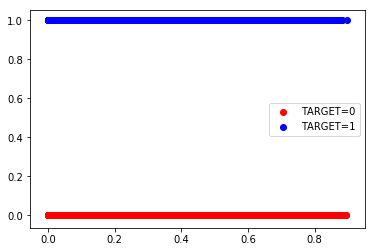

In [7]:
# 看不出具體的關係
plt.scatter(
    app_train[app_train['TARGET'] == 0]['EXT_SOURCE_3'],
    app_train[app_train['TARGET'] == 0]['TARGET'], marker='o', c='red', label='TARGET=0')
plt.scatter(
    app_train[app_train['TARGET'] == 1]['EXT_SOURCE_3'],
    app_train[app_train['TARGET'] == 1]['TARGET'], marker='o', c='blue', label='TARGET=1')
plt.legend()


Correlation: -0.1789


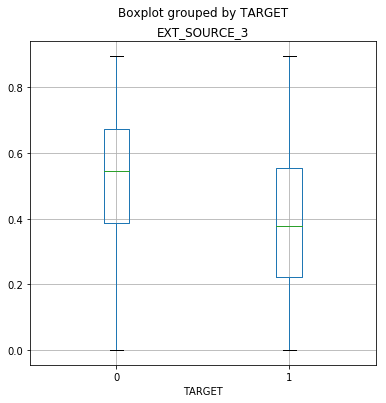

In [8]:
# 計算 correlation coefficient 時，要去除掉 np.nun
app_train.boxplot('EXT_SOURCE_3',by='TARGET', figsize=(6, 6))
corr = np.corrcoef(app_train[~app_train['EXT_SOURCE_3'].isnull()]['EXT_SOURCE_3'], app_train[~app_train['EXT_SOURCE_3'].isnull()]['TARGET'])
print("Correlation: %.4f" % (corr[0][1]))

### 觀察
可以看到 DAYS_BIRTH 有最高的正相關，不過還記得這個欄位的值其實是負值，表示說客戶的年紀越大，他們越不會發生遲繳貸款的狀況

這樣有一點混淆，我們就取一下這個欄位的絕對值吧，那麼這個欄位與 TARGET 就會變為負相關

In [9]:
# Find the correlation of the positive days since birth and target
app_train['DAYS_BIRTH'] = abs(app_train['DAYS_BIRTH'])
app_train['DAYS_BIRTH'].corr(app_train['TARGET'])

-0.07823930830982712

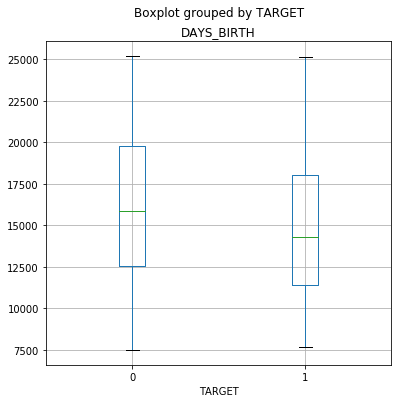

In [10]:
# 可見，在付款沒問題的情況下(target=0)，年齡層是較高的 (相較於 target=1)
app_train.boxplot('DAYS_BIRTH',by='TARGET', figsize=(6, 6))
